# Model Evaluation: Actual vs Predicted Values
This notebook loads the trained model and compares actual values to predicted values.

In [1]:
import torch
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
import os

In [3]:
df = pd.read_csv('../data/TBP_dataset.csv')
extra_colm = df.columns
draft_data = df[extra_colm].iloc[1:].reset_index(drop=True)
df = df.iloc[:-1].reset_index(drop=True)

In [4]:
scaler = StandardScaler()
X_normalized = pd.DataFrame(scaler.fit_transform(df), columns=df.columns)
Y_normalized = pd.DataFrame(scaler.fit_transform(draft_data), columns=draft_data.columns)
X = torch.tensor(X_normalized.values, dtype=torch.float32)
Y = torch.tensor(Y_normalized.values, dtype=torch.float32)
print('X shape:', X.shape)
print('Y shape:', Y.shape)

X shape: torch.Size([999999, 27])
Y shape: torch.Size([999999, 27])


In [5]:
import torch.nn as nn
import torch.nn.functional as F
class MeraModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(MeraModel, self).__init__()
        self.pf = nn.Linear(input_size, hidden_size*4)
        self.pf2 = nn.Linear(hidden_size*4, hidden_size*2)
        self.pf3 = nn.Linear(hidden_size*2, hidden_size)
        self.pf4a = nn.Linear(hidden_size, hidden_size)
        self.pf4b = nn.Linear(hidden_size, hidden_size)
        self.pf4 = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        x = F.relu(self.pf(x))
        x = F.relu(self.pf2(x))
        x = F.relu(self.pf3(x))
        x_a = F.relu(self.pf4a(x))
        x_b = F.relu(self.pf4b(x))
        x = x_a + x_b
        x = self.pf4(x)
        return x

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
input_size = X.shape[1]
hidden_size = 64
output_size = input_size
model = MeraModel(input_size, hidden_size, output_size).to(device)
model.load_state_dict(torch.load('mera_model_new_new.pth', map_location=device))  # Update path if needed
model.eval()

MeraModel(
  (pf): Linear(in_features=27, out_features=256, bias=True)
  (pf2): Linear(in_features=256, out_features=128, bias=True)
  (pf3): Linear(in_features=128, out_features=64, bias=True)
  (pf4a): Linear(in_features=64, out_features=64, bias=True)
  (pf4b): Linear(in_features=64, out_features=64, bias=True)
  (pf4): Linear(in_features=64, out_features=27, bias=True)
)

In [6]:
import numpy as np

n_samples = min(1000, X.shape[0], Y.shape[0])
with torch.no_grad():
    X_pred = X[:n_samples].to(device)
    
    start_idx = 0
    X_pred = X[start_idx:start_idx + n_samples].to(device)
    predictions = model(X_pred).cpu().numpy()
    actual = Y[start_idx:start_idx + n_samples].cpu().numpy()
    actual = Y[:n_samples].cpu().numpy()

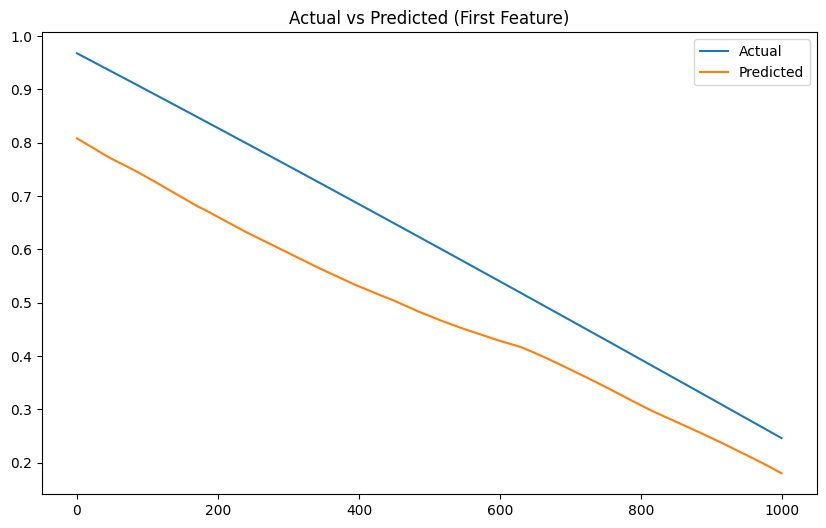

In [7]:
plt.figure(figsize=(10,6))
plt.plot(actual[:, 0], label='Actual')
plt.plot(predictions[:, 0], label='Predicted')
plt.legend()
plt.title('Actual vs Predicted (First Feature)')
plt.show()

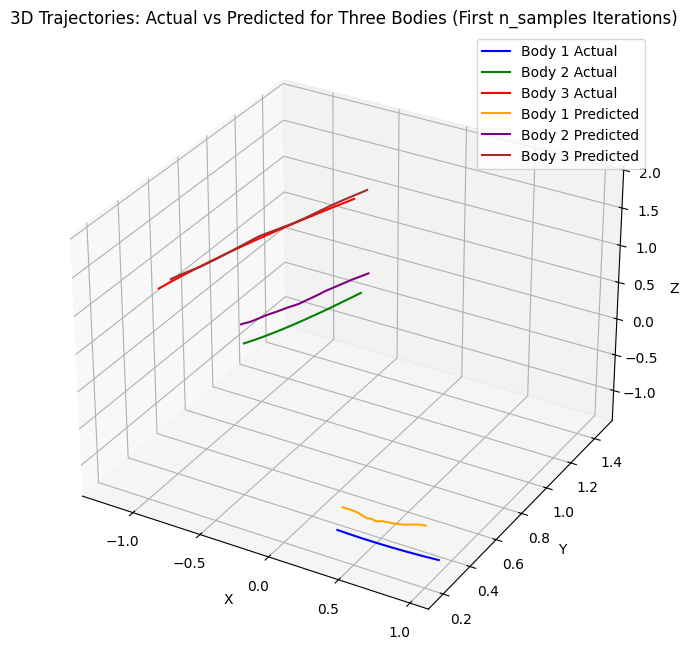

In [8]:
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure(figsize=(10,8))
ax = fig.add_subplot(111, projection='3d')

body1_actual = actual[:, :3]
body2_actual = actual[:, 3:6]
body3_actual = actual[:, 6:9]
body1_pred = predictions[:, :3]
body2_pred = predictions[:, 3:6]
body3_pred = predictions[:, 6:9]

ax.plot(body1_actual[:,0], body1_actual[:,1], body1_actual[:,2], label='Body 1 Actual', color='blue')
ax.plot(body2_actual[:,0], body2_actual[:,1], body2_actual[:,2], label='Body 2 Actual', color='green')
ax.plot(body3_actual[:,0], body3_actual[:,1], body3_actual[:,2], label='Body 3 Actual', color='red')

ax.plot(body1_pred[:,0], body1_pred[:,1], body1_pred[:,2], label='Body 1 Predicted', color='orange')
ax.plot(body2_pred[:,0], body2_pred[:,1], body2_pred[:,2], label='Body 2 Predicted', color='purple')
ax.plot(body3_pred[:,0], body3_pred[:,1], body3_pred[:,2], label='Body 3 Predicted', color='brown')

ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.set_title('3D Trajectories: Actual vs Predicted for Three Bodies (First n_samples Iterations)')
ax.legend()
plt.show()

Video saved as three_body_simulation_split.mp4


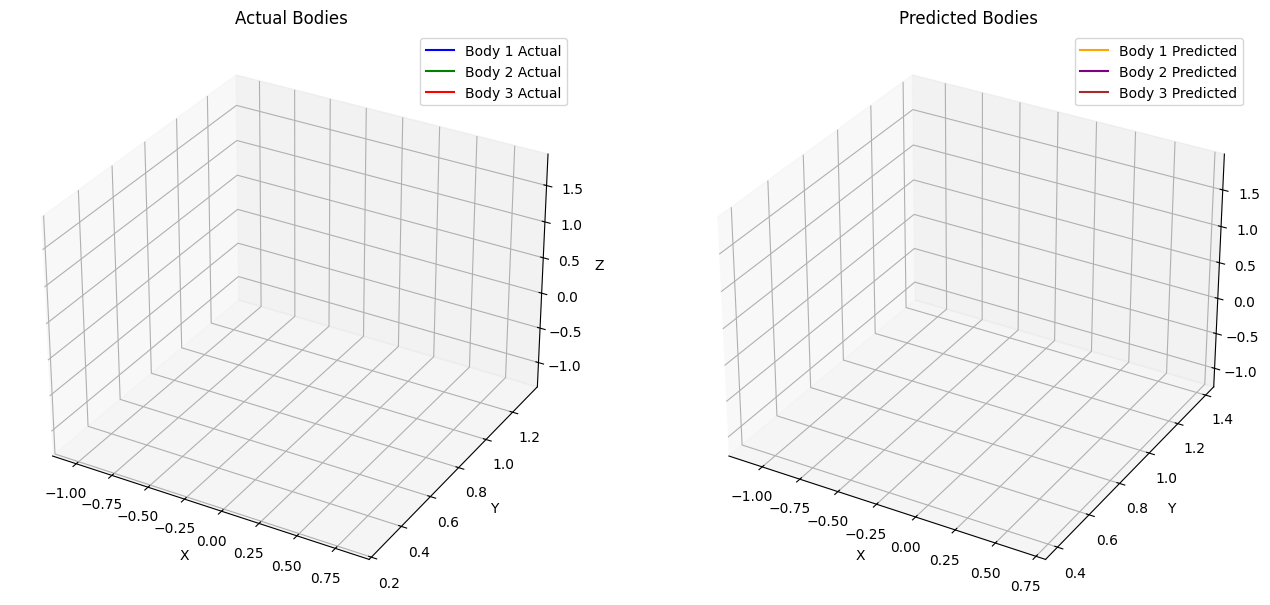

In [9]:
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import animation
import matplotlib.pyplot as plt
import numpy as np

fig = plt.figure(figsize=(16,8))
ax_left = fig.add_subplot(121, projection='3d')
ax_right = fig.add_subplot(122, projection='3d')

n_frames = actual.shape[0]
def update(frame):
    ax_left.clear()
    ax_right.clear()

    ax_left.plot(body1_actual[:frame,0], body1_actual[:frame,1], body1_actual[:frame,2], color='blue', label='Body 1 Actual')
    ax_left.plot(body2_actual[:frame,0], body2_actual[:frame,1], body2_actual[:frame,2], color='green', label='Body 2 Actual')
    ax_left.plot(body3_actual[:frame,0], body3_actual[:frame,1], body3_actual[:frame,2], color='red', label='Body 3 Actual')
    ax_left.set_xlabel('X')
    ax_left.set_ylabel('Y')
    ax_left.set_zlabel('Z')
    ax_left.set_title('Actual Bodies')
    ax_left.legend(loc='upper right')
    ax_left.set_xlim(np.min(actual[:,[0,3,6]]), np.max(actual[:,[0,3,6]]))
    ax_left.set_ylim(np.min(actual[:,[1,4,7]]), np.max(actual[:,[1,4,7]]))
    ax_left.set_zlim(np.min(actual[:,[2,5,8]]), np.max(actual[:,[2,5,8]]))

    ax_right.plot(body1_pred[:frame,0], body1_pred[:frame,1], body1_pred[:frame,2], color='orange', label='Body 1 Predicted')
    ax_right.plot(body2_pred[:frame,0], body2_pred[:frame,1], body2_pred[:frame,2], color='purple', label='Body 2 Predicted')
    ax_right.plot(body3_pred[:frame,0], body3_pred[:frame,1], body3_pred[:frame,2], color='brown', label='Body 3 Predicted')
    ax_right.set_xlabel('X')
    ax_right.set_ylabel('Y')
    ax_right.set_zlabel('Z')
    ax_right.set_title('Predicted Bodies')
    ax_right.legend(loc='upper right')
    ax_right.set_xlim(np.min(predictions[:,[0,3,6]]), np.max(predictions[:,[0,3,6]]))
    ax_right.set_ylim(np.min(predictions[:,[1,4,7]]), np.max(predictions[:,[1,4,7]]))
    ax_right.set_zlim(np.min(predictions[:,[2,5,8]]), np.max(predictions[:,[2,5,8]]))

ani = animation.FuncAnimation(fig, update, frames=n_frames, interval=10)

ani.save('three_body_simulation_split.mp4', writer='ffmpeg')
print('Video saved as three_body_simulation_split.mp4')